# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
book_cost=pd.read_excel("Book Cost.xlsx",index_col='Ticker')

In [7]:
quantities_api=Binance.binance_api.user_asset()
quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
quantities['asset']=quantities['asset']+'USDT'
quantities=quantities.set_index('asset')

In [8]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [9]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))

pnl=pd.concat([book_cost,holding.loc[condition]],axis=1)
pnl['Book Cost']=(pnl['Book Cost']*quantities['free'].astype(float))

realized_loss=63.514078
pnl.loc['Loss']=0
pnl.loc['Loss']['Book Cost']=realized_loss
pnl['Profit and Loss']=pnl['Price in USDT']-pnl['Book Cost']

pnl.loc['Total']=pnl.sum()
pnl.round(4)

,Book Cost,Price in USDT,Weights,Profit and Loss
BTCUSDT,611.9581,537.6320,0.2819,-74.3261
TRXUSDT,79.6748,74.9925,0.0393,-4.6823
JASMYUSDT,453.8661,247.1589,0.1296,-206.7072
SOLUSDT,261.7091,252.5957,0.1324,-9.1134
OMUSDT,535.6761,595.0663,0.3120,59.3902
ETHUSDT,264.2048,164.7612,0.0864,-99.4436
BBUSDT,46.3321,34.0040,0.0178,-12.3281
BNBUSDT,1.1490,0.9260,0.0005,-0.2231
PEPEUSDT,0.0000,0.0000,0.0000,0.0000
Loss,63.5141,0.0000,0.0000,-63.5141


In [10]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [11]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [12]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [13]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions

In [14]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [15]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
2024-09-02 00:00:00
LDTRXUSDT not retrieved
LDTRXUSDT


In [16]:
positions=positions.sort_index()

In [17]:
positions.index=pd.to_datetime(positions.index)

In [18]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [19]:
positions.to_excel('Positions.xlsx')
quantities.to_excel('Quantities.xlsx')

In [20]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [21]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [22]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [23]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [24]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [25]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [26]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

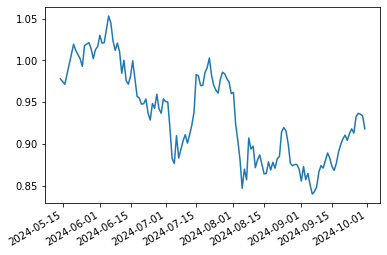

In [27]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [28]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [29]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [30]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'CFXUSDT', 'CKBUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'FTTUSDT', 'GALAUSDT', 'GRTUSDT',
       'HBARUSDT', 'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT',
       'LINKUSDT', 'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT'],
      dtype='object')

In [31]:
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [32]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit_hist[3]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3985
TRXUSDT,0.2591
BNBUSDT,0.2174
PEPEUSDT,0.0859
SUIUSDT,0.0310
JASMYUSDT,0.0071
USDCUSDT,0.0010
FDUSDUSDT,0.0000
WBTCUSDT,0.0000
BTCUSDT,0.0000


In [33]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.513395
BTCUSDT,0.400000
PEPEUSDT,0.086605


In [34]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [35]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.729061
OMUSDT,0.270939


## Real Portfolio vs Optimal

In [36]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,595.066287,0.312021,0.270939,0.041082
BTCUSDT,537.631957,0.281905,0.000000,0.000000
SOLUSDT,252.595713,0.132448,0.000000,0.000000
JASMYUSDT,247.158863,0.129597,0.000000,0.000000
ETHUSDT,164.761195,0.086392,0.000000,0.000000
TRXUSDT,74.992500,0.039322,0.729061,-0.689739
BBUSDT,34.004002,0.017830,0.000000,0.000000
BNBUSDT,0.925973,0.000485,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.000000,0.000000


In [37]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,595.066287,0.312021,0.513395,-0.201374
BTCUSDT,537.631957,0.281905,0.400000,-0.118095
SOLUSDT,252.595713,0.132448,0.000000,0.000000
JASMYUSDT,247.158863,0.129597,0.000000,0.000000
ETHUSDT,164.761195,0.086392,0.000000,0.000000
TRXUSDT,74.992500,0.039322,0.000000,0.000000
BBUSDT,34.004002,0.017830,0.000000,0.000000
BNBUSDT,0.925973,0.000485,0.000000,0.000000
PEPEUSDT,0.000002,0.000000,0.086605,-0.086605


# Risk Reward Analysis

In [38]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [39]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

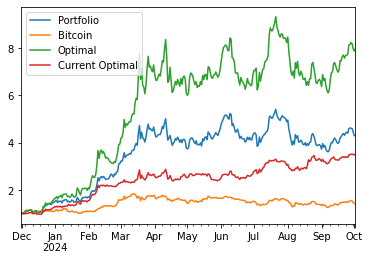

In [40]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [41]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

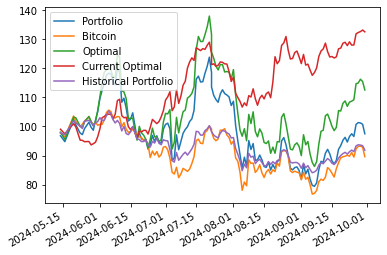

In [42]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [43]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-09-21,96.272961,89.770777,108.801154,128.998153,91.097867
2024-09-22,94.647046,90.095833,106.940875,127.844076,90.480102
2024-09-23,96.555229,89.756842,108.405957,129.150961,91.298984
2024-09-24,97.487374,91.054949,108.714022,128.005193,91.853987
2024-09-25,96.552138,89.467434,109.192741,128.064589,91.339446
2024-09-26,100.698338,92.287070,114.724230,131.909319,93.306318
2024-09-27,101.345012,93.127121,114.984749,132.356820,93.693252
2024-09-28,101.214387,93.251712,116.283571,132.673520,93.595109
2024-09-29,100.739542,92.888537,115.455888,133.206931,93.379558
2024-09-30,97.490094,89.610942,112.571343,132.591518,91.840967


## Volatilities

In [44]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.765013
dtype: float64

In [45]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.544829
dtype: float64

In [46]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.607904
Bitcoin            0.441532
Optimal            0.766228
Current Optimal    0.430011
dtype: float64

In [47]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.20396457576902643

## Risk Contribution

In [48]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.172302,0.400000,0.047253,0.142046,0.053129,0.088918
OMUSDT,10.743203,0.513395,0.929425,0.790939,0.700969,0.089970
PEPEUSDT,0.195853,0.086605,0.023322,0.067014,0.021168,0.045846


In [49]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.131998,0.270939,0.315415,0.51746,0.453249,0.064211
TRXUSDT,0.145487,0.729061,0.684585,0.48254,0.418329,0.064211


In [50]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.151028,0.31,0.436614,0.397182,0.230667,0.166516
BTCUSDT,-0.022337,0.28,0.244018,0.179984,0.045291,0.134693
SOLUSDT,-0.020164,0.13,0.104019,0.129515,0.025295,0.104220
JASMYUSDT,-0.024809,0.13,0.099620,0.183359,0.054341,0.129018
ETHUSDT,-0.023275,0.09,0.063191,0.069962,0.008157,0.061805
TRXUSDT,0.007982,0.04,0.045441,0.006342,0.000490,0.005853
BBUSDT,-0.012507,0.02,0.007096,0.033656,0.002718,0.030938


# Value At Risk

## Historical

In [51]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06374251833490725, -0.08952236631714754)

In [52]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.050205866337809095, -0.06811693136225423)

In [53]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [54]:
var=historical_var.iloc[row]
var

OMUSDT      -0.019835
BTCUSDT     -0.011955
SOLUSDT     -0.003879
JASMYUSDT   -0.007035
ETHUSDT     -0.006914
TRXUSDT      0.000286
BBUSDT      -0.000880
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050212
Name: 2024-08-04 00:00:00, dtype: float64

In [55]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.025710
BTCUSDT     -0.012441
SOLUSDT     -0.009451
JASMYUSDT   -0.012774
ETHUSDT     -0.005275
TRXUSDT     -0.000637
BBUSDT      -0.001829
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068117
dtype: float64

## Parametric

In [56]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07939355579489897, -0.1017605874266069)

In [57]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.056453057819404864, -0.07235721171843446)

## Multivariate

In [58]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07238640566047451, -0.0925520656965345)

In [59]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05571045864093924, -0.07006543570428178)

In [60]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.020952
BTCUSDT     -0.009594
SOLUSDT     -0.007552
JASMYUSDT   -0.011428
ETHUSDT     -0.003693
TRXUSDT     -0.000263
BBUSDT      -0.001848
Portfolio   -0.055331
dtype: float64

## Copulas

### Gaussian Copula

In [61]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0720347012592434, -0.09297294316716148)

In [62]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05465333940593398, -0.0695645712570197)

In [63]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.020954
BTCUSDT     -0.010311
SOLUSDT     -0.007254
JASMYUSDT   -0.009982
ETHUSDT     -0.004369
TRXUSDT     -0.000382
BBUSDT      -0.002088
Portfolio   -0.055339
dtype: float64

### Student Copula

In [64]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07108504396627004, -0.09194789107312636)

In [65]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05606415475298581, -0.07108423017484287)

In [66]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.021674
BTCUSDT     -0.010667
SOLUSDT     -0.007051
JASMYUSDT   -0.010471
ETHUSDT     -0.004227
TRXUSDT     -0.000260
BBUSDT      -0.002000
Portfolio   -0.056352
dtype: float64

### Gumbel Copula

In [67]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.14900992794140439, -0.20868556612155312)

In [68]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0704363675060769, -0.09962359719726781)

In [69]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.044801
BTCUSDT     -0.007260
SOLUSDT     -0.002587
JASMYUSDT   -0.014396
ETHUSDT     -0.002075
TRXUSDT     -0.000064
BBUSDT      -0.000678
Portfolio   -0.071862
dtype: float64

### Monte Carlo

In [70]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [71]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08128206156363438, -0.10124617052227337)

In [72]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.058548577719093976, -0.07226278430375231)

In [73]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.023938
BTCUSDT     -0.010106
SOLUSDT     -0.006792
JASMYUSDT   -0.010527
ETHUSDT     -0.003944
TRXUSDT     -0.000260
BBUSDT      -0.001925
Portfolio   -0.057491
dtype: float64

## VaR Violation

In [74]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.063436,-0.113811,-0.096268,-0.025602
2024-01-15,-0.063436,-0.113814,-0.095011,0.014844
2024-01-16,-0.063436,-0.114645,-0.094770,0.064797
2024-01-17,-0.063436,-0.117083,-0.096832,-0.037196
2024-01-18,-0.063436,-0.119211,-0.101133,-0.036285
...,...,...,...,...
2024-09-28,-0.042627,-0.073699,-0.066340,0.011296
2024-09-29,-0.042627,-0.073967,-0.066662,-0.007118
2024-09-30,-0.042627,-0.074728,-0.067254,-0.024984
2024-10-01,-0.042627,-0.073133,-0.065768,-0.012746


In [75]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.031509,-0.084747,-0.079272,-0.017262
2024-05-29,-0.029128,-0.081905,-0.075866,-0.010039
2024-05-30,-0.029128,-0.070969,-0.065809,0.035294
2024-05-31,-0.029128,-0.070173,-0.060633,0.028469
2024-06-01,-0.029128,-0.071726,-0.061723,0.042960
...,...,...,...,...
2024-09-28,-0.025112,-0.048206,-0.040341,-0.001289
2024-09-29,-0.025087,-0.046407,-0.038601,-0.004691
2024-09-30,-0.030105,-0.048146,-0.040037,-0.032256
2024-10-01,-0.032252,-0.052534,-0.047755,-0.032229


<AxesSubplot:>

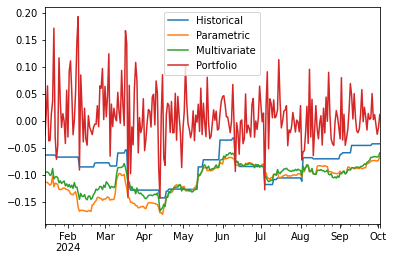

In [76]:
var_data.plot()

<AxesSubplot:>

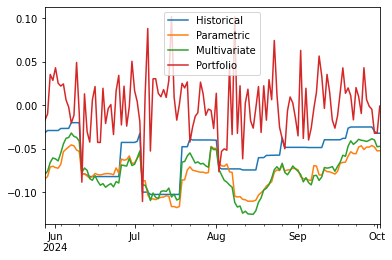

In [77]:
current_var_data.plot()

In [78]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022814,0.007605,0.011407
Kupiec Stat,5.086741,15.257249,11.840008
P-value,0.024109,0.000094,0.00058


In [79]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.0625,0.023438,0.023438
Kupiec Stat,0.391442,2.348078,2.348078
P-value,0.531542,0.125438,0.125438


## Principal Component Analysis

### Historical PCA

In [80]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.78667001, 0.06724498, 0.05370545, 0.047248  , 0.04513155])

In [81]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014221
ADAUSDT     0.014543
ALGOUSDT    0.016028
APTUSDT     0.015281
ARBUSDT     0.015732
              ...   
WBTCUSDT    0.010074
WLDUSDT     0.021819
XECUSDT     0.015585
XLMUSDT     0.009711
XRPUSDT     0.009308
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

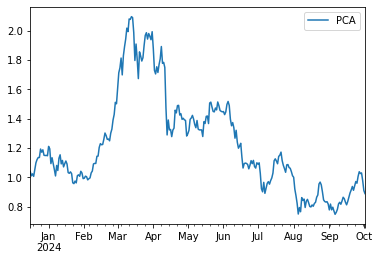

In [82]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

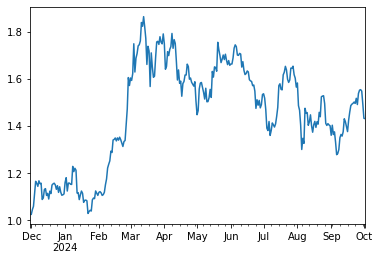

In [83]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [84]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ADAUSDT      0.340256
ALGOUSDT     0.349348
ETHUSDT      0.355217
WBETHUSDT    0.355255
               ...   
PEPEUSDT     1.001512
FLOKIUSDT    1.010782
WLDUSDT      1.046788
CKBUSDT      1.153869
OMUSDT       1.320675
Length: 65, dtype: float64

<AxesSubplot:>

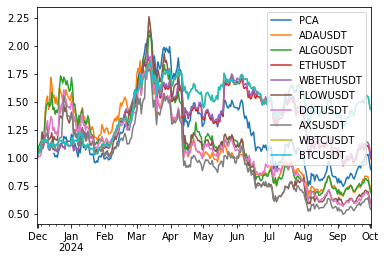

In [85]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

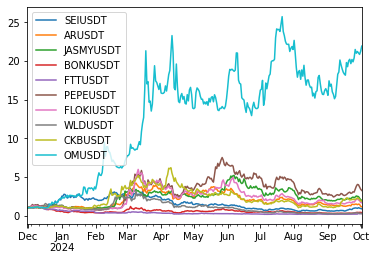

In [86]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

### Current PCA

In [87]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.67154976, 0.13806041, 0.08848317, 0.07017794, 0.03172873])

In [88]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.095947
BTCUSDT      0.064520
SOLUSDT      0.103883
JASMYUSDT    0.155645
ETHUSDT      0.086702
TRXUSDT      0.015484
BBUSDT       0.244428
BNBUSDT      0.068647
PEPEUSDT     0.164743
Name: PC1, dtype: float64

<AxesSubplot:>

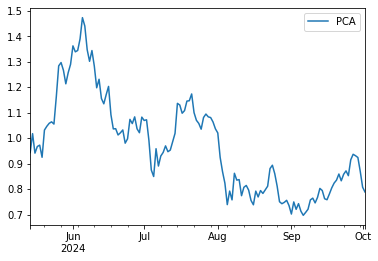

In [89]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

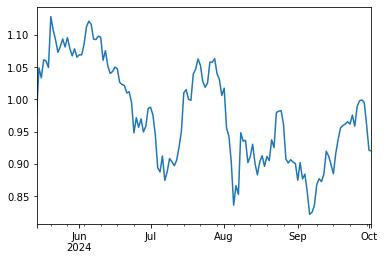

In [90]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [91]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
ETHUSDT      0.334972
SOLUSDT      0.345761
BNBUSDT      0.368920
BTCUSDT      0.369007
JASMYUSDT    0.427243
PEPEUSDT     0.472766
TRXUSDT      0.549958
OMUSDT       0.554036
BBUSDT       0.629269
dtype: float64

<AxesSubplot:>

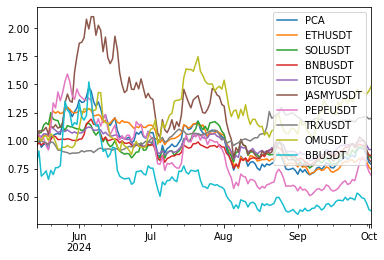

In [92]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [93]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.947048
BBUSDT       1.697645
JASMYUSDT    1.297931
SOLUSDT      1.167084
BTCUSDT      1.000000
OMUSDT       0.975522
ETHUSDT      0.956763
BNBUSDT      0.677828
TRXUSDT      0.280402
Name: BTCUSDT, dtype: float64

In [94]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     2.430229
BBUSDT       2.330220
JASMYUSDT    1.966230
SOLUSDT      1.467172
ETHUSDT      1.049090
BTCUSDT      1.000000
BNBUSDT      0.956319
OMUSDT       0.340972
TRXUSDT      0.309453
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [95]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451
